In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1" 

import numpy as np
import pandas as pd
import sys
 
import re

sys.path.append('/shareb/zliu/analysis/')
sys.path.append('/shareb/zliu/analysis/CHARMtools')
from CHARMtools import Cell3Ddev as Cell3D
from CHARMtools import MultiCell3D

import importlib
importlib.reload(Cell3D)
import matplotlib.pyplot as plt
import seaborn as sns

import concurrent.futures
import tqdm
from sklearn.cluster import DBSCAN

from CHARMtools import spatialstat
import multiprocessing

from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu
from scipy import stats
from scipy.spatial import ConvexHull
plt.rcParams['pdf.use14corefonts'] = True
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['axes.grid'] = False

/tmp/ipykernel_3854664/2792709810.py:38: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [2]:
metadata = pd.read_csv('../data/metadata/metadata.tsv', sep='\t')
metadata = metadata[metadata['5k'] < 2].reset_index(drop=True)

atac_peaks = pd.read_table("../1_preprocess/atacpeak_score50.bed",header=None)
atac_peaks.columns = ["chrom","start","end"]
ct_peaks = pd.read_table("../data/publicdata/ENCODE/ENCFF008XKX_encode_mESCBruce4_H3K27me3.bed.gz",header=None).iloc[:,:3]
ct_peaks.columns = ["chrom","start","end"]

rnag1 = pd.read_csv("../data/RNAmats/counts.gene.total.format.tsv.gz",sep='\t')
rnag2 = pd.read_csv("../data/RNAmats/counts.gene.total.format.tsv.gz",sep='\t')
genes = pd.read_csv("/share/Data/public/ref_genome/mouse_ref/M23/raw_data/gene.bed",sep='\t')

In [3]:
sox2data = pd.read_csv("/home/zliu/mnt/zliu_ssd/CHARM/CHARM_brain/4_cregene/metacell_allcells/data/Sox2.tsv.gz",sep="\t")

In [4]:
# show all rows 
pd.set_option('display.max_rows', 20)
sox2data_mesc = sox2data.query('cellname.str.startswith("P")').query('pos == 34755000').merge(
    rnag1.query('gene == "Sox2"').set_index("gene").T.reset_index().rename(columns={"index":"cellname"}),
    on="cellname", how="left"
)

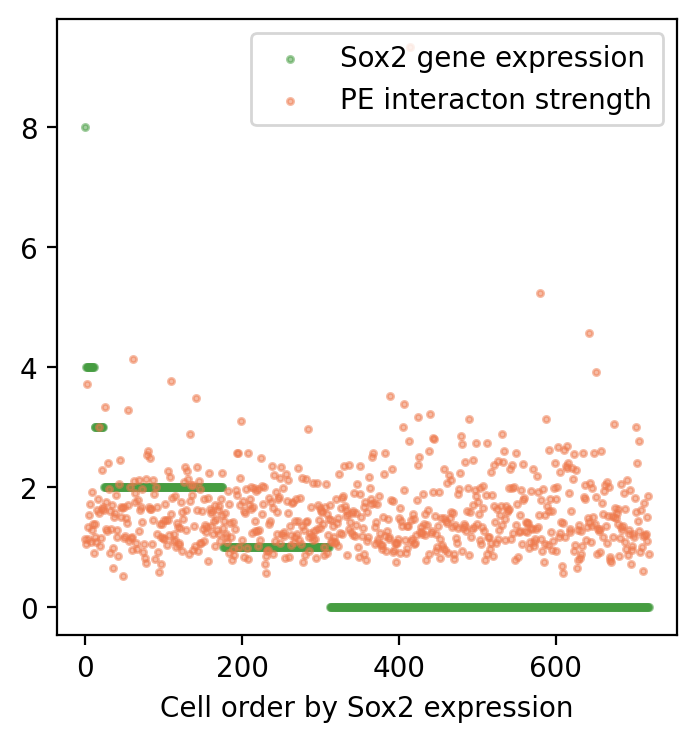

In [57]:
pdata = sox2data_mesc.sort_values("Sox2",ascending=False).reset_index()
pdata["order"] = range(len(pdata))

plt.figure(figsize=(4, 4))
plt.scatter(pdata["order"], round(pdata["Sox2"]), s=5, c="#469d41", alpha=0.5)
plt.scatter(pdata["order"], pdata["obsexp_contact"], s=5, c="#ee794c", alpha=0.5)

#plt.ylabel("Sox2 expression")
plt.xlabel("Cell order by Sox2 expression")
plt.legend(["Sox2 gene expression", "PE interacton strength"], loc="upper right")

plt.savefig("figures/Sox2_scatter.pdf", bbox_inches='tight')

Mann-Whitney U test p-value: 0.7231999841122916
T-test p-value: 0.981933126782888


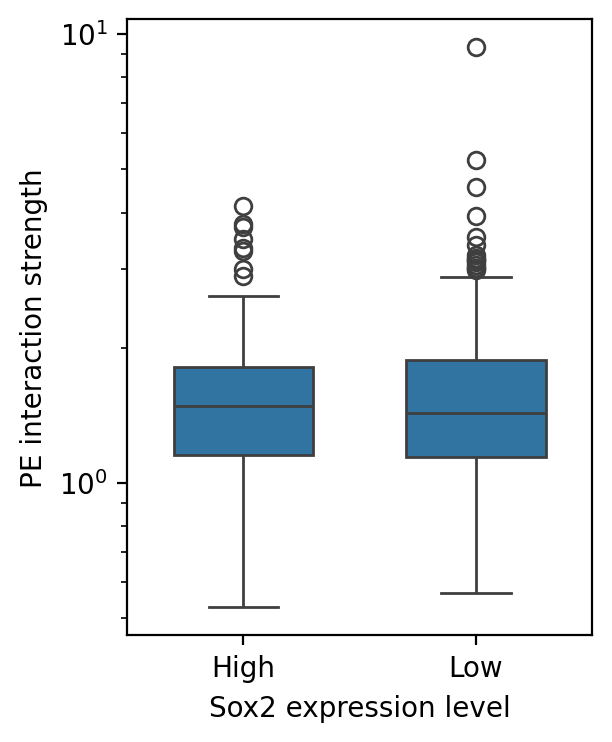

In [54]:
plt.figure(figsize=(3, 4))
pdata["round_exp"] = round(pdata["Sox2"])
pdata["exp_level"] = "Low"
pdata.loc[pdata["round_exp"] > 1, "exp_level"] = "High"

sns.boxplot(x="exp_level", y="obsexp_contact", data=pdata,width=0.6)
# log scale
plt.yscale("log")
plt.ylabel("PE interaction strength")
plt.xlabel("Sox2 expression level")

# print the p-value
print("Mann-Whitney U test p-value:", mannwhitneyu(pdata.query('exp_level == "Low"')["obsexp_contact"], pdata.query('exp_level == "High"')["obsexp_contact"]).pvalue)
print("T-test p-value:", stats.ttest_ind(pdata.query('exp_level == "Low"')["obsexp_contact"], pdata.query('exp_level == "High"')["obsexp_contact"]).pvalue)
plt.savefig("figures/sox2_expression_contact_strength_boxplot.pdf", bbox_inches="tight")


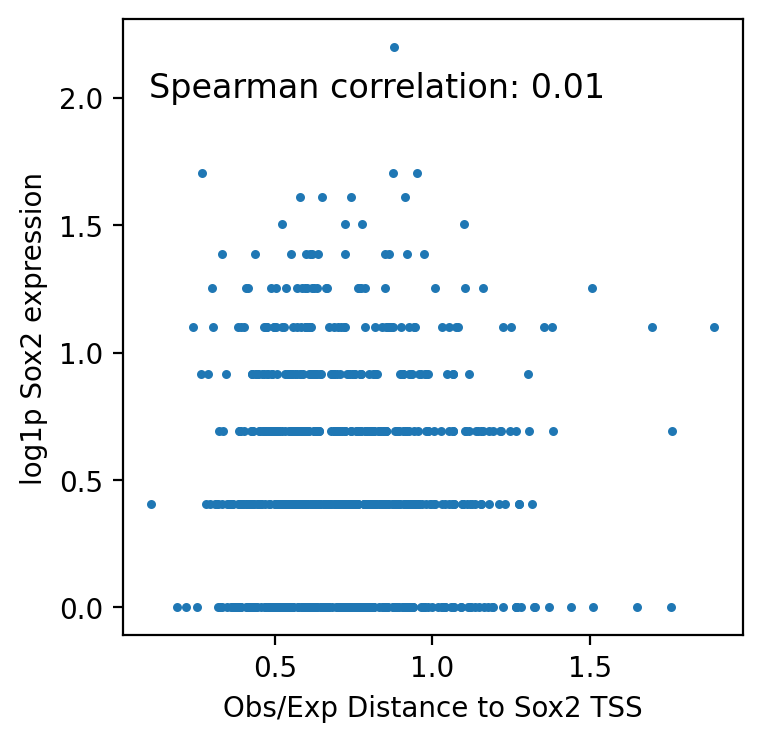

In [58]:
plt.figure(figsize=(4, 4))
plt.scatter(sox2data_mesc["obsexp_distance"], np.log1p(sox2data_mesc["Sox2"]), s=5)
plt.xlabel("Obs/Exp Distance to Sox2 TSS")
plt.ylabel("log1p Sox2 expression")

# calculate spearman correlation
spearman_corr = stats.spearmanr(sox2data_mesc["obsexp_distance"], np.log1p(sox2data_mesc["Sox2"]))
plt.text(0.1, 2, f"Spearman correlation: {spearman_corr.correlation:.2f}", fontsize=12)

# remove grid
plt.grid(False)
plt.show()


In [61]:
print(stats.spearmanr(sox2data_mesc["obsexp_distance"], np.log1p(sox2data_mesc["Sox2"])))
print(stats.pearsonr(sox2data_mesc["obsexp_distance"], np.log1p(sox2data_mesc["Sox2"])))

SignificanceResult(statistic=0.0086869755517706, pvalue=0.8159979409685908)
PearsonRResult(statistic=0.00745646323818757, pvalue=0.8416893679906825)


Text(0, 0.5, 'Obs/Exp Distance to Sox2 TSS')

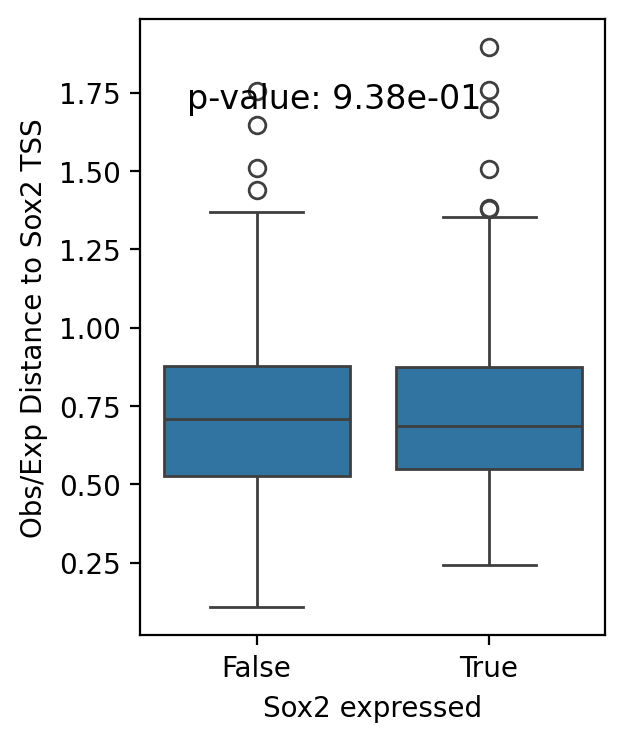

In [8]:
sox2data_mesc["expressed"] = sox2data_mesc["Sox2"] >= 1

# boxplot of distance , groupby expressed
plt.figure(figsize=(3, 4))
sns.boxplot(x="expressed", y="obsexp_distance", data=sox2data_mesc)
# add significant test
stat, p = mannwhitneyu(
    sox2data_mesc.query('expressed == True')["obsexp_distance"],
    sox2data_mesc.query('expressed == False')["obsexp_distance"]
)
plt.text(-0.3, 1.7, f"p-value: {p:.2e}", fontsize=12)
plt.xlabel("Sox2 expressed")
plt.ylabel("Obs/Exp Distance to Sox2 TSS")


Text(0, 0.5, 'Distance to Sox2 TSS')

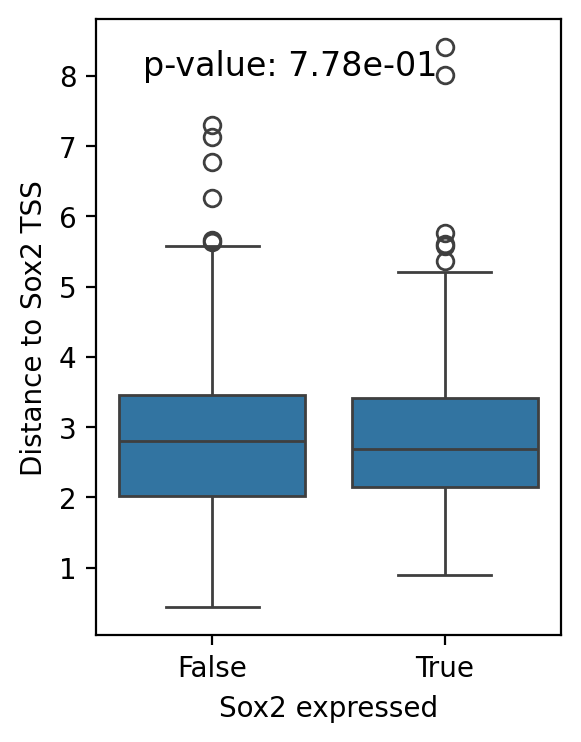

In [9]:
sox2data_mesc["expressed"] = sox2data_mesc["Sox2"] >= 1

# boxplot of distance , groupby expressed
plt.figure(figsize=(3, 4))
sns.boxplot(x="expressed", y="distance", data=sox2data_mesc)
# add significant test
stat, p = mannwhitneyu(
    sox2data_mesc.query('expressed == True')["distance"],
    sox2data_mesc.query('expressed == False')["distance"]
)
plt.text(-0.3, 8, f"p-value: {p:.2e}", fontsize=12)
plt.xlabel("Sox2 expressed")
plt.ylabel("Distance to Sox2 TSS")
